In [1]:
from rlnoise.dataset import Dataset
from rlnoise.utils import dataset_folder
import numpy as np
import matplotlib.pyplot as plt

Create and save dataset (1st use)

In [2]:
nqubits = 1
ngates = 5
ncirc = 100

# create dataset
print("Creating random cicuits")
dataset = Dataset(
    n_circuits=ncirc,
    n_gates=ngates,
    n_qubits=nqubits,
)
print("Generating cicuits representation")
circuits_repr=dataset.generate_dataset_representation()
print("Adding noise")
dataset.add_noise(noise_params=0.07)
print("Measuring observables")
labels=dataset.generate_labels()

np.save(dataset_folder() + '/dataset_1q.npy', circuits_repr)
np.save(dataset_folder() + '/labels_1q.npy', labels)
print("Circuits and labels saved in: ", dataset_folder())

Creating random cicuits
Generating cicuits representation
Adding noise
Measuring observables


[Qibo 0.1.10.dev0|INFO|2023-02-09 17:13:36]: Using tensorflow backend on /device:CPU:0


Load existing dataset

In [2]:
circuits_repr = np.load(dataset_folder() + '/dataset_1q.npy')
labels = np.load(dataset_folder() + '/labels_1q.npy')

print("Dataset loaded")
print("Number of circuits: ", len(circuits_repr))

Dataset loaded
Number of circuits:  100


Visualize circuit representation and observables distributions moments

In [3]:
element=0

print("Circuit representation:")
print(circuits_repr[element])
print("Observables distribution moments:")
print(labels[element])

Circuit representation:
[[0.         0.54156335]
 [0.         0.37195697]
 [0.         0.21414577]
 [1.         0.80536387]
 [0.         0.53812583]]
Observables distribution moments:
[[0.328      0.006464  ]
 [0.2062     0.00944556]
 [0.199      0.009235  ]]


Create RL environment

In [4]:
from rlnoise.envs.gym_env import CircuitsGym
from rlnoise.utils import truncated_moments_matching

env=CircuitsGym(circuits_repr, labels, reward_func=truncated_moments_matching)
#env.set_reward_func(truncated_moments_matching)

Define ANN

In [5]:
import tensorflow as tf
from tensorflow import keras

num_inputs = env.observation_space.shape
num_actions = env.action_space.n

# CNN model
inputs = keras.layers.Input(shape=num_inputs)
common = keras.layers.Conv1D(8, (1,), activation="relu")(inputs)
common = keras.layers.Conv1D(4, (3,), padding='same', activation="relu")(common)
common = keras.layers.Flatten()(common)
action = keras.layers.Dense(num_actions, activation="softmax", name='Actor')(common)
critic = keras.layers.Dense(1, name='Critic')(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])
model.summary()

2023-02-09 17:28:43.424539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simonebordoni/anaconda3/envs/qibo/lib/python3.10/site-packages/cv2/../../lib64:


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 8)         40          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5, 4)         100         ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 20)           0           ['conv1d_1[0][0]']               
                                                                                              

2023-02-09 17:28:44.561552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simonebordoni/anaconda3/envs/qibo/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-09 17:28:44.561593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simonebordoni/anaconda3/envs/qibo/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-09 17:28:44.561620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simonebordoni/anaconda3/envs/qibo/lib/python3.10/site-packages/cv2/../../lib64:
20

Define Agent

In [6]:
from rlnoise.agents.actor_critic import AC_agent

agent=AC_agent(model, env)
agent.train_val_split(split=0.1)
agent.validation_options(do_validation=True, val_steps=20, greedy_policy=True)

Train set elements:  90
Validation set elements:  10


Train Agent

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
episodes=100

train_history, val_history = agent.train(episodes=episodes, optimizer=optimizer)

[Qibo 0.1.10.dev0|INFO|2023-02-09 17:29:07]: Using tensorflow backend on /device:CPU:0


episode: 10, avg_reward 0.052331
episode: 20, avg_reward 0.046962
episode: 20, val_reward 0.056153
episode: 30, avg_reward 0.050079
episode: 40, avg_reward 0.055014
episode: 40, val_reward 0.048426
episode: 50, avg_reward 0.052001
episode: 60, avg_reward 0.049117
episode: 60, val_reward 0.056874
episode: 70, avg_reward 0.046438
episode: 80, avg_reward 0.052835
episode: 80, val_reward 0.055531
episode: 90, avg_reward 0.052466
episode: 100, avg_reward 0.055413
episode: 100, val_reward 0.058460


Visualize training history

AttributeError: 'list' object has no attribute 'set_xlabel'

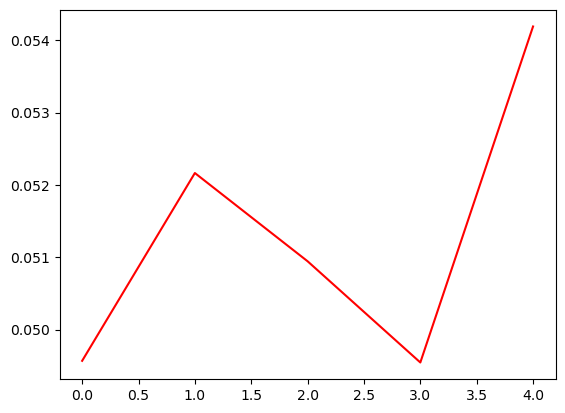

In [15]:
from rlnoise.utils import plot_results
plot_results(train_history=train_history, val_history=val_history, n_steps=20)

In [22]:
print(train_history[94])

{'circuit': 60, 'reward': 0.05579700667984001, 'final_state': array([[0.        , 0.08317755, 0.        , 0.        ],
       [1.        , 0.7326649 , 1.        , 0.        ],
       [1.        , 0.2620227 , 1.        , 0.        ],
       [1.        , 0.10362229, 1.        , 0.        ],
       [0.        , 0.7618408 , 0.        , 1.        ]], dtype=float32)}
